In [1]:
# Import the required packages
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

## Read Data

In [2]:
train_df = pd.read_csv("../data/travel_insurance_prediction_train.csv")
test_df = pd.read_csv("../data/travel_insurance_prediction_test.csv")

## Model training: Boosting

In [3]:
from sklearn.compose import make_column_transformer
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder

### Transform the columns into features: Using baseline transformers

In [4]:
columnas_disc = ["Age", "AnnualIncome"]
columnas_vect = ["Employment Type", "GraduateOrNot", "FamilyMembers", "FrequentFlyer", "EverTravelledAbroad"]

transformer = make_column_transformer(
    (KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="quantile"), columnas_disc),
    (OneHotEncoder(categories="auto", dtype="int", handle_unknown="ignore"), columnas_vect),
    remainder="passthrough")

We transform the train and test data. In order to avoid overfitting is better to remove the `Customer` column and we don't want the `TravelInsurance` column as part of the attributes either.

In [5]:
# The data for training the model
X_train = transformer.fit_transform(train_df.drop(columns=["Customer", "TravelInsurance"]))
y_train = train_df["TravelInsurance"].values

# The test data is only for generating the submission
X_test = transformer.transform(test_df.drop(columns=["Customer"]))

## Boosting

Entrenaremos en esta notebook un modelo de Boosting utilizando la libreria xgboost.

In [6]:
!pip install xgboost

You should consider upgrading via the 'c:\users\nico ch\.conda\envs\diplodatos-ayvd\python.exe -m pip install --upgrade pip' command.


In [7]:
import xgboost as xgb
from sklearn.utils.fixes import loguniform
from scipy import stats

In [8]:
xg_clf = xgb.XGBClassifier(random_state=0) #objective = "multi:softmax", colsample_bytree = 0.3, learning_rate = 0.1,
                           #max_depth = 5, alpha = 10, n_estimators = 10

In [9]:
model_parameters_xgb = {'objective' : ['binary:logistic','binary:hinge'],
                        'colsample_bytree' :[0.3,0.5,0.8],
                        'learning_rate': loguniform(1e-2, 1e2),    
                        'max_depth': [3,5,10,20,50],
                        #'alpha': loguniform(1e-2, 1e2),
                        'n_estimators': [5,10,50,100,200,750],
                        'min_samples_leaf': [2,3,5,10]
                        }
                    #'min_samples_leaf': [np.random.randint(1,10)], 
                    #'max_features': [None, 'sqrt', 'log2']}

In [10]:
XGB_models = RandomizedSearchCV(xg_clf, model_parameters_xgb, random_state=0, cv=5, 
                                scoring='f1', n_jobs=-1, n_iter=100)
XGB_models.fit(X_train, y_train)

C:\Users\Nico Ch\.conda\envs\diplodatos-ayvd\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:38:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "min_samples_leaf" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           validate_parameters=None,
                                           verbosity=None),
                   n_iter=100, n_jobs=-1,
          

In [11]:
best_XGB_models = XGB_models.best_estimator_
best_XGB_models

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.08944813408783459, max_delta_step=0, max_depth=5,
              min_child_weight=1, min_samples_leaf=10, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=4,
              num_parallel_tree=1, objective='binary:hinge', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [12]:
XGB_results=XGB_models.cv_results_
XGB_results_fr=pd.DataFrame(XGB_results)
XGB_results_fr[XGB_results_fr.rank_test_score<5][['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,params,mean_test_score,std_test_score,rank_test_score
14,"{'colsample_bytree': 0.3, 'learning_rate': 0.0...",0.711347,0.043656,4
44,"{'colsample_bytree': 0.3, 'learning_rate': 0.0...",0.713312,0.039290,1
57,"{'colsample_bytree': 0.3, 'learning_rate': 0.0...",0.711660,0.036494,2
89,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.711429,0.034287,3


In [13]:
XGB_results_fr.params.values[XGB_results_fr.rank_test_score<5]

array([{'colsample_bytree': 0.3, 'learning_rate': 0.09499535455183794, 'max_depth': 3, 'min_samples_leaf': 3, 'n_estimators': 750, 'objective': 'binary:hinge'},
       {'colsample_bytree': 0.3, 'learning_rate': 0.08944813408783459, 'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 200, 'objective': 'binary:hinge'},
       {'colsample_bytree': 0.3, 'learning_rate': 0.0723640636578332, 'max_depth': 20, 'min_samples_leaf': 2, 'n_estimators': 200, 'objective': 'binary:hinge'},
       {'colsample_bytree': 0.8, 'learning_rate': 0.02365036380805937, 'max_depth': 50, 'min_samples_leaf': 10, 'n_estimators': 50, 'objective': 'binary:logistic'}],
      dtype=object)

## Check Results

### Confusion matrix

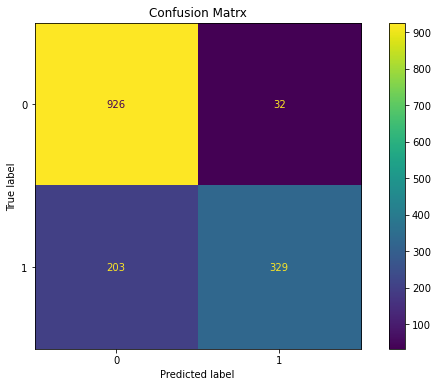

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.grid(False)
ax.set_title('Confusion Matrx')

disp = plot_confusion_matrix(best_XGB_models, X_train, y_train, ax = ax)

### Clasification report

In [15]:
print(classification_report(y_train, best_XGB_models.predict(X_train)))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89       958
           1       0.91      0.62      0.74       532

    accuracy                           0.84      1490
   macro avg       0.87      0.79      0.81      1490
weighted avg       0.85      0.84      0.83      1490



## Generate the output

The last thing we do is generating a file that should be *submitted* on kaggle

In [16]:
test_id = test_df["Customer"]
test_pred = best_XGB_models.predict(X_test)

submission = pd.DataFrame(list(zip(test_id, test_pred)), columns=["Customer", "TravelInsurance"])
submission.to_csv("../data/travel_insurance_submission.csv", header=True, index=False)